# 01. 비트코인 데이터 수집

**목표:** Binance에서 BTC/USDT OHLCV 데이터를 수집하고 로컬에 저장

- 라이브러리: `ccxt` (API 키 없이도 퍼블릭 데이터 수집 가능)
- 수집 대상: 1시간봉 (1h), 2018-01-01 ~ 현재
- 저장 형식: CSV


## 0. 라이브러리 설치 확인

In [1]:
# 필요한 라이브러리 설치 (최초 1회)
# !pip install ccxt pandas numpy python-dotenv tqdm

## 1. Import 및 기본 설정

In [2]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timezone
from tqdm import tqdm

print(f"ccxt version: {ccxt.__version__}")
print(f"pandas version: {pd.__version__}")

ccxt version: 4.5.39
pandas version: 3.0.1


In [3]:
# ─────────────────────────────────────────────
#  설정값 (여기만 수정하면 됩니다)
# ─────────────────────────────────────────────
SYMBOL     = 'BTC/USDT'      # 수집할 심볼
TIMEFRAME  = '1h'            # 캔들 단위: '1m', '5m', '15m', '1h', '4h', '1d'
START_DATE = '2018-01-01'    # 수집 시작일
END_DATE   = None            # None이면 현재까지 수집

# 저장 경로
RAW_DATA_DIR = '../data/raw'
os.makedirs(RAW_DATA_DIR, exist_ok=True)

# 저장 파일명
SAVE_PATH = os.path.join(RAW_DATA_DIR, 'btc_usdt_1h_ohlcv.csv')

print(f"수집 대상: {SYMBOL} / {TIMEFRAME}")
print(f"수집 기간: {START_DATE} ~ {'현재' if END_DATE is None else END_DATE}")
print(f"저장 경로: {SAVE_PATH}")

수집 대상: BTC/USDT / 1h
수집 기간: 2018-01-01 ~ 현재
저장 경로: ../data/raw\btc_usdt_1h_ohlcv.csv


## 2. Binance 거래소 연결

> **API 키 없이** 퍼블릭 OHLCV 데이터 수집이 가능합니다.  
> 실매매가 필요할 때만 API 키를 발급하면 됩니다.

In [4]:
# Binance 거래소 인스턴스 생성 (API 키 불필요)
exchange = ccxt.binance({
    'enableRateLimit': True,   # API 요청 속도 자동 제한 (필수)
    'options': {
        'defaultType': 'spot',  # spot 시장 사용
    }
})

# 연결 테스트
try:
    markets = exchange.load_markets()
    print(f"✅ Binance 연결 성공")
    print(f"   지원 심볼 수: {len(markets)}개")
    print(f"   {SYMBOL} 존재 여부: {SYMBOL in markets}")
except Exception as e:
    print(f"❌ 연결 실패: {e}")

✅ Binance 연결 성공
   지원 심볼 수: 4230개
   BTC/USDT 존재 여부: True


## 3. OHLCV 데이터 수집 함수

Binance는 한 번에 최대 **1,000개** 캔들만 반환합니다.  
2018년부터 현재까지 1시간봉을 모두 수집하려면 약 **45,000개+** 이므로  
페이지네이션(pagination) 방식으로 반복 수집합니다.

In [5]:
def fetch_ohlcv_full(
    exchange,
    symbol: str,
    timeframe: str,
    start_date: str,
    end_date: str = None,
    batch_size: int = 1000,
    sleep_sec: float = 0.5,
) -> pd.DataFrame:
    """
    ccxt를 사용해 OHLCV 데이터를 전체 기간 수집합니다.
    
    Parameters
    ----------
    exchange   : ccxt 거래소 인스턴스
    symbol     : 'BTC/USDT' 형식
    timeframe  : '1m', '5m', '15m', '1h', '4h', '1d'
    start_date : 'YYYY-MM-DD' 형식
    end_date   : 'YYYY-MM-DD' 형식 또는 None (현재까지)
    batch_size : 한 번에 요청할 캔들 수 (Binance 최대: 1000)
    sleep_sec  : 요청 간 대기 시간 (초)
    
    Returns
    -------
    pd.DataFrame : timestamp 인덱스의 OHLCV DataFrame
    """
    
    # 시작/종료 타임스탬프 (밀리초 단위)
    since_ms = exchange.parse8601(start_date + 'T00:00:00Z')
    if end_date:
        end_ms = exchange.parse8601(end_date + 'T00:00:00Z')
    else:
        end_ms = exchange.milliseconds()
    
    all_ohlcv = []
    current_ms = since_ms
    
    print(f"수집 시작: {symbol} {timeframe}")
    print(f"기간: {start_date} ~ {'현재' if end_date is None else end_date}")
    print("-" * 50)
    
    with tqdm(desc="캔들 수집 중", unit="batch") as pbar:
        while current_ms < end_ms:
            try:
                # OHLCV 요청
                ohlcv_batch = exchange.fetch_ohlcv(
                    symbol=symbol,
                    timeframe=timeframe,
                    since=current_ms,
                    limit=batch_size,
                )
                
                # 데이터가 없으면 종료
                if not ohlcv_batch:
                    break
                
                # end_ms 이후 데이터 제거
                ohlcv_batch = [c for c in ohlcv_batch if c[0] < end_ms]
                
                all_ohlcv.extend(ohlcv_batch)
                
                # 다음 배치 시작점 = 마지막 캔들의 다음 캔들
                last_ts = ohlcv_batch[-1][0]
                current_ms = last_ts + exchange.parse_timeframe(timeframe) * 1000
                
                pbar.update(1)
                pbar.set_postfix({
                    '수집량': f"{len(all_ohlcv):,}개",
                    '현재': datetime.fromtimestamp(last_ts/1000).strftime('%Y-%m-%d')
                })
                
                time.sleep(sleep_sec)
                
            except ccxt.NetworkError as e:
                print(f"\n⚠️ 네트워크 오류: {e} → 5초 후 재시도")
                time.sleep(5)
            except ccxt.ExchangeError as e:
                print(f"\n❌ 거래소 오류: {e}")
                break
    
    if not all_ohlcv:
        print("수집된 데이터가 없습니다.")
        return pd.DataFrame()
    
    # DataFrame 변환
    df = pd.DataFrame(
        all_ohlcv,
        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
    )
    
    # 타임스탬프 처리
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    df.set_index('timestamp', inplace=True)
    df.index = df.index.tz_convert('Asia/Seoul')  # 한국 시간으로 변환 (원하면 'UTC' 유지)
    
    # 타입 변환
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
    
    # 중복 제거 및 정렬
    df = df[~df.index.duplicated(keep='first')]
    df.sort_index(inplace=True)
    
    print(f"\n✅ 수집 완료!")
    print(f"   총 {len(df):,}개 캔들")
    print(f"   기간: {df.index[0]} ~ {df.index[-1]}")
    
    return df

## 4. 데이터 수집 실행

> ⏱️ 2018년부터 현재까지 1시간봉 기준 약 **3~5분** 소요됩니다.

In [6]:
df_raw = fetch_ohlcv_full(
    exchange=exchange,
    symbol=SYMBOL,
    timeframe=TIMEFRAME,
    start_date=START_DATE,
    end_date=END_DATE,
)

df_raw.head()

수집 시작: BTC/USDT 1h
기간: 2018-01-01 ~ 현재
--------------------------------------------------


캔들 수집 중: 72batch [00:42,  1.68batch/s, 수집량=71,216개, 현재=2026-02-20]


✅ 수집 완료!
   총 71,216개 캔들
   기간: 2018-01-01 09:00:00+09:00 ~ 2026-02-20 18:00:00+09:00


,open,high,low,close,volume
timestamp,,,,,
2018-01-01 09:00:00+09:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 10:00:00+09:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 11:00:00+09:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 12:00:00+09:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 13:00:00+09:00,13434.98,13623.29,13322.15,13601.01,340.807329


## 5. 데이터 품질 검사

In [7]:
def check_data_quality(df: pd.DataFrame, timeframe: str = '1h') -> None:
    """
    수집된 OHLCV 데이터의 품질을 검사합니다.
    """
    print("=" * 50)
    print("📊 데이터 품질 검사")
    print("=" * 50)
    
    # 기본 정보
    print(f"\n[ 기본 정보 ]")
    print(f"  전체 행 수     : {len(df):,}개")
    print(f"  시작일         : {df.index[0]}")
    print(f"  종료일         : {df.index[-1]}")
    print(f"  컬럼           : {list(df.columns)}")
    
    # 결측값 확인
    print(f"\n[ 결측값 ]")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("  ✅ 결측값 없음")
    else:
        print(f"  ⚠️ 결측값 발견:\n{null_counts[null_counts > 0]}")
    
    # 시간 연속성 확인 (캔들 누락 검사)
    print(f"\n[ 시간 연속성 ]")
    freq_map = {'1m': '1min', '5m': '5min', '15m': '15min', 
                '1h': '1h', '4h': '4h', '1d': '1D'}
    expected_freq = freq_map.get(timeframe, '1h')
    
    expected_index = pd.date_range(
        start=df.index[0], end=df.index[-1], freq=expected_freq, tz=df.index.tz
    )
    missing_candles = expected_index.difference(df.index)
    
    if len(missing_candles) == 0:
        print("  ✅ 시간 연속성 정상 (누락 캔들 없음)")
    else:
        print(f"  ⚠️ 누락 캔들 {len(missing_candles):,}개 발견")
        print(f"  첫 번째 누락: {missing_candles[0]}")
        print(f"  마지막 누락: {missing_candles[-1]}")
    
    # 가격 이상값 확인
    print(f"\n[ 가격 통계 ]")
    print(df[['open', 'high', 'low', 'close']].describe().round(2))
    
    # 논리적 이상값 확인 (high < low 등)
    print(f"\n[ 논리 검증 ]")
    anomaly_hl = df[df['high'] < df['low']]
    anomaly_oc = df[(df['open'] > df['high']) | (df['open'] < df['low'])]
    anomaly_cc = df[(df['close'] > df['high']) | (df['close'] < df['low'])]
    
    print(f"  high < low 이상 : {len(anomaly_hl)}개")
    print(f"  open 범위 이탈  : {len(anomaly_oc)}개")
    print(f"  close 범위 이탈 : {len(anomaly_cc)}개")
    
    if len(anomaly_hl) + len(anomaly_oc) + len(anomaly_cc) == 0:
        print("  ✅ 논리적 이상값 없음")
    
    # 거래량 0 확인
    zero_vol = df[df['volume'] == 0]
    print(f"\n[ 거래량 ]")
    print(f"  거래량 0인 캔들: {len(zero_vol)}개")
    
    print("\n" + "=" * 50)


check_data_quality(df_raw, timeframe=TIMEFRAME)

📊 데이터 품질 검사

[ 기본 정보 ]
  전체 행 수     : 71,216개
  시작일         : 2018-01-01 09:00:00+09:00
  종료일         : 2026-02-20 18:00:00+09:00
  컬럼           : ['open', 'high', 'low', 'close', 'volume']

[ 결측값 ]
  ✅ 결측값 없음

[ 시간 연속성 ]
  ⚠️ 누락 캔들 122개 발견
  첫 번째 누락: 2018-01-04 13:00:00+09:00
  마지막 누락: 2023-03-24 22:00:00+09:00

[ 가격 통계 ]
            open       high        low      close
count   71216.00   71216.00   71216.00   71216.00
mean    38051.19   38203.97   37890.63   38051.96
std     32507.73   32606.73   32405.08   32507.80
min      3172.62    3184.75    3156.26    3172.05
25%      9523.89    9567.96    9480.03    9523.81
50%     27925.60   28013.27   27855.06   27926.66
75%     58831.82   59090.01   58573.14   58833.42
max    126011.18  126199.63  125252.74  126011.18

[ 논리 검증 ]
  high < low 이상 : 0개
  open 범위 이탈  : 0개
  close 범위 이탈 : 0개
  ✅ 논리적 이상값 없음

[ 거래량 ]
  거래량 0인 캔들: 3개



## 6. 누락 캔들 처리 (Forward Fill)

누락 캔들이 있는 경우, 직전 캔들의 close 가격으로 채웁니다.  
(거래소 점검 등으로 인한 짧은 공백은 forward fill이 일반적인 처리법)

In [8]:
def fill_missing_candles(df: pd.DataFrame, timeframe: str = '1h') -> pd.DataFrame:
    """
    누락된 캔들을 forward fill 방식으로 보완합니다.
    """
    freq_map = {'1m': '1min', '5m': '5min', '15m': '15min',
                '1h': '1h', '4h': '4h', '1d': '1D'}
    freq = freq_map.get(timeframe, '1h')
    
    # 전체 시간 인덱스 생성
    full_index = pd.date_range(
        start=df.index[0], end=df.index[-1], freq=freq, tz=df.index.tz
    )
    
    before_count = len(df)
    
    # 리인덱싱 후 forward fill
    df_filled = df.reindex(full_index)
    
    # close는 직전 close로 채움
    df_filled['close'] = df_filled['close'].ffill()
    
    # open, high, low도 close(=직전 close)로 채움 (doji 캔들처럼)
    for col in ['open', 'high', 'low']:
        df_filled[col] = df_filled[col].fillna(df_filled['close'])
    
    # 거래량 0으로 채움
    df_filled['volume'] = df_filled['volume'].fillna(0)
    
    after_count = len(df_filled)
    filled_count = after_count - before_count
    
    print(f"누락 캔들 {filled_count}개를 forward fill로 보완했습니다.")
    
    return df_filled


df_clean = fill_missing_candles(df_raw, timeframe=TIMEFRAME)
print(f"처리 전: {len(df_raw):,}개 → 처리 후: {len(df_clean):,}개")

누락 캔들 122개를 forward fill로 보완했습니다.
처리 전: 71,216개 → 처리 후: 71,338개


## 7. 데이터 시각화 (간단 확인)

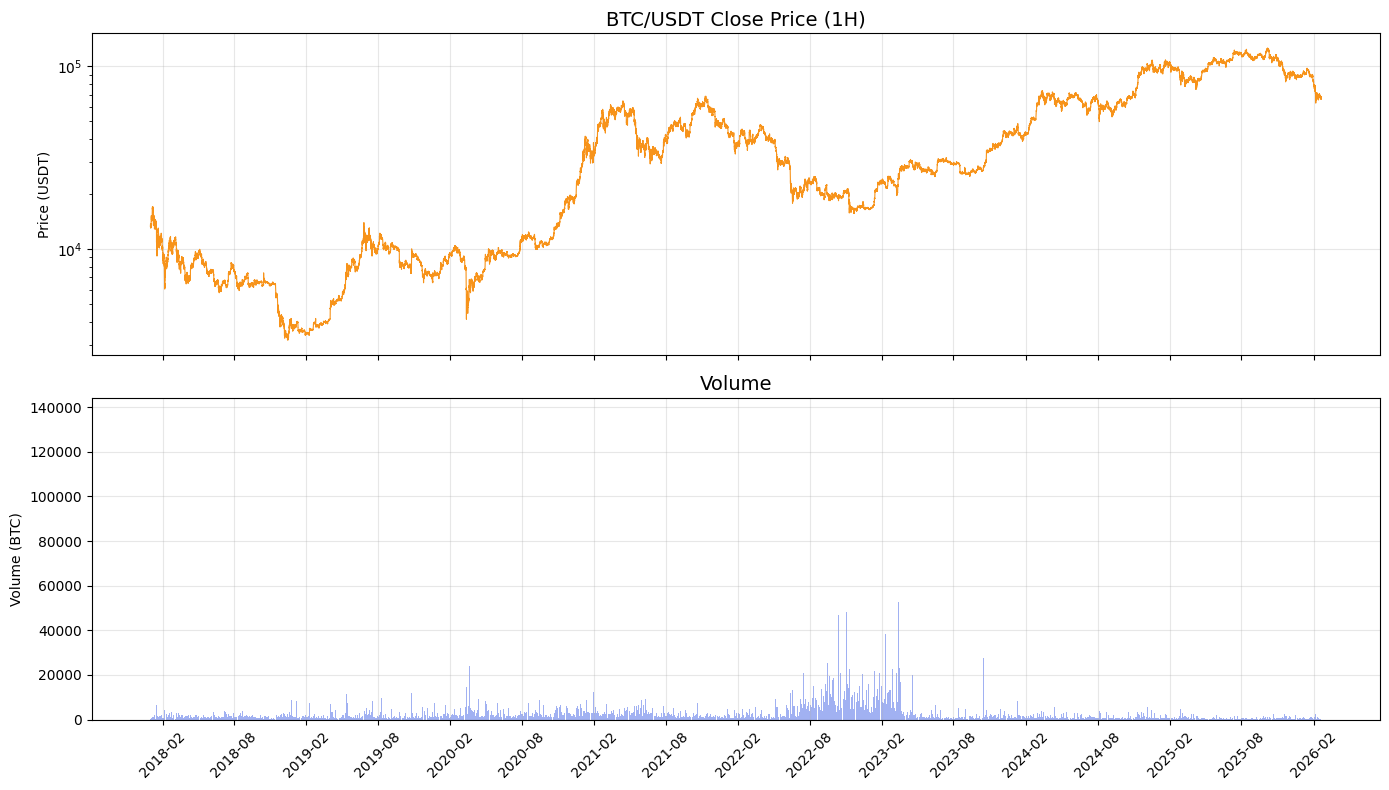

차트 저장 완료


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 종가 차트
axes[0].plot(df_clean.index, df_clean['close'], color='#F7931A', linewidth=0.8)
axes[0].set_title('BTC/USDT Close Price (1H)', fontsize=14)
axes[0].set_ylabel('Price (USDT)')
axes[0].set_yscale('log')   # 로그 스케일로 보면 전체 구간이 잘 보임
axes[0].grid(alpha=0.3)

# 거래량 차트
axes[1].bar(df_clean.index, df_clean['volume'], color='#627EEA', alpha=0.6, width=0.04)
axes[1].set_title('Volume', fontsize=14)
axes[1].set_ylabel('Volume (BTC)')
axes[1].grid(alpha=0.3)

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RAW_DATA_DIR, 'btc_price_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print("차트 저장 완료")

## 8. Train / Validation / Test 분할 및 저장

```
Train      : 2018-01-01 ~ 2023-06-30  (학습용)
Validation : 2023-07-01 ~ 2024-03-31  (하이퍼파라미터 튜닝용)
Test       : 2024-04-01 ~ 현재         (최종 평가용 - 절대 학습에 사용 금지)
```

In [10]:
# 분할 기준일
TRAIN_END = '2023-06-30 23:00'
VAL_END   = '2024-03-31 23:00'

# tz-aware 비교를 위해 타임존 지정
tz = df_clean.index.tz

train_mask = df_clean.index <= pd.Timestamp(TRAIN_END, tz=tz)
val_mask   = (df_clean.index > pd.Timestamp(TRAIN_END, tz=tz)) & \
             (df_clean.index <= pd.Timestamp(VAL_END, tz=tz))
test_mask  = df_clean.index > pd.Timestamp(VAL_END, tz=tz)

df_train = df_clean[train_mask]
df_val   = df_clean[val_mask]
df_test  = df_clean[test_mask]

print("📂 데이터 분할 결과")
print("-" * 50)
print(f"Train  : {len(df_train):>7,}개  ({df_train.index[0].date()} ~ {df_train.index[-1].date()})")
print(f"Val    : {len(df_val):>7,}개  ({df_val.index[0].date()} ~ {df_val.index[-1].date()})")
print(f"Test   : {len(df_test):>7,}개  ({df_test.index[0].date()} ~ {df_test.index[-1].date()})")
total = len(df_clean)
print("-" * 50)
print(f"Train 비율: {len(df_train)/total*100:.1f}%")
print(f"Val   비율: {len(df_val)/total*100:.1f}%")
print(f"Test  비율: {len(df_test)/total*100:.1f}%")

📂 데이터 분할 결과
--------------------------------------------------
Train  :  48,159개  (2018-01-01 ~ 2023-06-30)
Val    :   6,600개  (2023-07-01 ~ 2024-03-31)
Test   :  16,579개  (2024-04-01 ~ 2026-02-20)
--------------------------------------------------
Train 비율: 67.5%
Val   비율: 9.3%
Test  비율: 23.2%


In [11]:
# 저장
SPLIT_DIR = '../data/splits'
os.makedirs(SPLIT_DIR, exist_ok=True)

# 원본 전체 데이터 저장
df_clean.to_csv(SAVE_PATH)

# 분할 데이터 저장
df_train.to_csv(os.path.join(SPLIT_DIR, 'train.csv'))
df_val.to_csv(os.path.join(SPLIT_DIR, 'val.csv'))
df_test.to_csv(os.path.join(SPLIT_DIR, 'test.csv'))

print("✅ 저장 완료!")
print(f"  전체 데이터  : {SAVE_PATH}")
print(f"  Train 데이터 : {SPLIT_DIR}/train.csv")
print(f"  Val 데이터   : {SPLIT_DIR}/val.csv")
print(f"  Test 데이터  : {SPLIT_DIR}/test.csv")

✅ 저장 완료!
  전체 데이터  : ../data/raw\btc_usdt_1h_ohlcv.csv
  Train 데이터 : ../data/splits/train.csv
  Val 데이터   : ../data/splits/val.csv
  Test 데이터  : ../data/splits/test.csv


## 9. 저장된 데이터 검증 (다음 노트북 이전 최종 확인)

In [13]:
# 저장된 파일 다시 불러와서 확인
df_check = pd.read_csv(SAVE_PATH, index_col=0, parse_dates=True)

print("✅ 저장/로드 검증")
print(f"  행 수    : {len(df_check):,}개")
print(f"  컬럼     : {list(df_check.columns)}")
print(f"  Null 수  : {df_check.isnull().sum().sum()}")
print()
print(df_check.head(3))

✅ 저장/로드 검증
  행 수    : 71,338개
  컬럼     : ['open', 'high', 'low', 'close', 'volume']
  Null 수  : 0

                               open      high       low     close      volume
2018-01-01 09:00:00+09:00  13715.65  13715.65  13400.01  13529.01  443.356199
2018-01-01 10:00:00+09:00  13528.99  13595.89  13155.38  13203.06  383.697006
2018-01-01 11:00:00+09:00  13203.00  13418.43  13200.00  13330.18  429.064572


---

## ✅ 완료 요약

| 단계 | 내용 | 상태 |
|---|---|---|
| 데이터 수집 | Binance BTC/USDT 1H OHLCV | ✅ |
| 품질 검사 | 결측값, 연속성, 논리 이상값 | ✅ |
| 누락 보완 | Forward Fill | ✅ |
| 시각화 | 전체 기간 가격/거래량 차트 | ✅ |
| 분할 저장 | Train / Val / Test | ✅ |

**다음 단계:** `02_feature_engineering.ipynb` — 기술적 지표 계산 및 정규화